In [431]:
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, ConvLSTM2D, LSTM, GRU
from tensorflow.keras.layers import RepeatVector, Activation, MaxPooling3D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall, PrecisionAtRecall, RecallAtPrecision
from sklearn.model_selection import train_test_split
from pyproj import CRS
import geopandas as gpd
import pandas as pd
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import random
import pickle
import rtree

In [95]:
diam = 40

def generate_grid(fire_file_path, centroid_x, centroid_y):
    fires = gpd.read_file(fire_file_path)
    fires = fires.to_crs(epsg=3310)

    # Get bounds of CRS
    x_min, y_min, x_max, y_max = (-5198207.57, -1564155.99, 6820717.07, 5283999.14)

    # Get the max polygon from shp file
    polygons = fires.geometry
    max_fire = None
    for polygon in polygons:
        if polygon is None:
            continue
        if not max_fire or polygon.area > max_fire.area:
            max_fire = polygon
            
    if max_fire is None:
        raise ValueError

    # Generate points for each sqkm
    points = []

    topleft_x = int(centroid_x - (diam / 2) * 1000)
    topleft_y = int(centroid_y - (diam / 2) * 1000)

    points = [(x, y) for x in range(topleft_x, topleft_x + diam * 1000, 1000) for y in range(topleft_y, topleft_y + diam * 1000, 1000)]

    # Generate boolean grid    
    points_gdf = gpd.GeoDataFrame(index=list(range(diam ** 2)), crs='EPSG:3310', geometry=[Point(p) for p in points])
    
    max_fire_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:3310', geometry=[max_fire])
    
    join = gpd.sjoin(points_gdf, max_fire_gdf, how='left', predicate='within')
    join['in'] = join['index_right'].notnull().astype(int)
    
    grid = np.asarray(join['in']).reshape(-1, diam)
    x_grid = np.asarray([(x - x_min) / (x_max - x_min) for x, _ in points]).reshape(-1, diam)
    y_grid = np.asarray([(y - y_min) / (y_max - y_min) for _, y in points]).reshape(-1, diam)
    
#     print(grid)
#     print(x_grid)
#     print(y_grid)

    return grid, x_grid, y_grid

In [109]:
DATE_FORMAT_CODE = '%Y%m%d'

dataset_path = "./download/cleaned_fire_data/"

all_data = []

def preprocess_all(dataset_path):
    regions = os.listdir(dataset_path)
    for i, region in enumerate(sorted(regions)):
        print(i, region)
        if region != '.DS_Store':
            date_path = os.path.join(dataset_path, region, 'GIS')
            dates = os.listdir(date_path)
            dates.sort() # Sort dates so that earliest date occur first
            dates.remove(".DS_Store")
            
            # Obtain centroid for first date
            fire_file_path = os.path.join(date_path, dates[0])
            fire_file_name = list(pathlib.Path(fire_file_path).glob('*.shp'))
            
            if not fire_file_name:
                continue
            
            try:
                fires = gpd.read_file(fire_file_name[0])
                fires = fires.to_crs(epsg=3310)
                polygons = fires.geometry
                max_fire = None
                for polygon in polygons:
                    if polygon is None:
                        continue
                    if not max_fire or polygon.area > max_fire.area:
                        max_fire = polygon
                        
                # If first date does not have a fire, we skip the region
                if not max_fire:
                    continue

                centroid_x = max_fire.centroid.x
                centroid_y = max_fire.centroid.y
            except:
                continue
            
            for i, date in enumerate(dates):
                # Check if 5 days in future exists
                date_time_obj = datetime.strptime(date, DATE_FORMAT_CODE)
                fire_file_path = os.path.join(date_path, date)
                fire_file_name = list(pathlib.Path(fire_file_path).glob('*.shp'))
                
                if not fire_file_name:
                    continue
                    
                try:
                    grid, x_grid, y_grid = generate_grid(fire_file_name[0], centroid_x, centroid_y)
                except ValueError as e:
                    continue
                    
#                 print(datetime.strftime(date_time_obj, DATE_FORMAT_CODE))

                all_data.append([date_time_obj, region, grid, x_grid, y_grid])
                
#                 break
#             break
                        
            
#             with open('all_data.pkl', 'wb') as f:
#                 pickle.dump(all_data, f)

preprocess_all(dataset_path)
with open('all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

0 .DS_Store
1 CA-AEU-024918_Butte


ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-AEU-024918_Butte/GIS/20150914/20150913_2309_Butte_CAAEU024918_Poly_FirePolygon_NAD_1983_California_Teale_Albers.shx or download/cleaned_fire_data/CA-AEU-024918_Butte/GIS/20150914/20150913_2309_Butte_CAAEU024918_Poly_FirePolygon_NAD_1983_California_Teale_Albers.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


2 CA-BDF-013409_El_Dorado
3 CA-BDF_007894_Lake
4 CA-BEU-003422_Soberanes


ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-BEU-003422_Soberanes/GIS/20160904/20160903_1806_Soberanes_16CABEU003422_Poly_FirePolygon_NAD_1983_California_Teale_Albers.shx or download/cleaned_fire_data/CA-BEU-003422_Soberanes/GIS/20160904/20160903_1806_Soberanes_16CABEU003422_Poly_FirePolygon_NAD_1983_California_Teale_Albers.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


5 CA-BTU-009205_Dixie


ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-BTU-009692_BTU%20Lightning%20Complex/GIS/20200821/20200820_BTU-GTU_CABTU009841_EventPolygon.shx or download/cleaned_fire_data/CA-BTU-009692_BTU%20Lightning%20Complex/GIS/20200821/20200820_BTU-GTU_CABTU009841_EventPolygon.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


6 CA-BTU-009692_BTU%20Lightning%20Complex
7 CA-BTU-016737_Camp
8 CA-CZU-005205_CZU_Lightning_Complex
9 CA-ENF-024030_Caldor
10 CA-ENF-024030_Caldor_CALFIRE
11 CA-HIA-000115_MillCreek1
12 CA-HUU-005606_Humboldt_Complex
13 CA-KNF-004500_Pony
14 CA-KNF-005956_Happy_Camp_Cmplx
15 CA-KNF-006081_Salmon_August_Complex
16 CA-KNF-007501_Gap
17 CA-KNF-5659_Fort_Complex
18 CA-KNF-5949_Forks_Complex
19 CA-KNF-6098_Eclipse_Complex
20 CA-KNF-6385_RiverComplex
21 CA-KNP-000122_KNPComplex
22 CA-LMU-003917_Gold
23 CA-LNU-010045_Central_LNU_Complex
24 CA-LNU-010105_SouthernLNUComplex
25 CA-LNU-013407_LNU_Lightning_Complex
26 CA-LNU-015947_Glass
27 CA-LNU-019376_Kincade
28 CA-LPF-002428_Dolan
29 CA-LPF-002809_Rey
30 CA-MEU-007202_LodgeLightningComplex
31 CA-MEU-008674_Mendocino_Complex
32 CA-MEU-010843_August_Complex_West_Zone
33 CA-NOD-004727_W-5ColdSprings
34 CA-PNF-001308_PNF_North_Complex
35 CA-PNF-001324_Walker
36 CA-PNF-1064_Beckwourth
37 CA-SCU-005740_SCU_Lightning_Complex
38 CA-SHF-000017_Cutthro

ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-SHF-001770_Helena/GIS/20170903/EventPolygon 1.34.18 AM.shx or download/cleaned_fire_data/CA-SHF-001770_Helena/GIS/20170903/EventPolygon 1.34.18 AM.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.
ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-SHF-001770_Helena/GIS/20170904/EventPolygon 1.34.39 AM.shx or download/cleaned_fire_data/CA-SHF-001770_Helena/GIS/20170904/EventPolygon 1.34.39 AM.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


43 CA-SHF-001770_Helena
44 CA-SHF-001850_Buck
45 CA-SHF-002066_River_Complex


ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-SHF-002066_River_Complex/GIS/20150811/20150811_0753_RiverComplex_CA_SHF002066_Poly_FirePolygon_NAD_1983_UTM_Zone_10N.shx or download/cleaned_fire_data/CA-SHF-002066_River_Complex/GIS/20150811/20150811_0753_RiverComplex_CA_SHF002066_Poly_FirePolygon_NAD_1983_UTM_Zone_10N.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


46 CA-SHF-002067_Fork_Complex
47 CA-SHF-002108_South_Complex
48 CA-SHU-006248_BULLY
49 CA-SHU-006933_Eiler
50 CA-SHU-007808_Carr
51 CA-SHU-009978_Zogg
52 CA-SLU-008948_Chimney
53 CA-SNF-0001743_Railroad
54 CA-SNF-000745_Ferguson
55 CA-SNF-001391_Creek
56 CA-SNF_001732_Aspen


ERROR:fiona._env:Unable to open download/cleaned_fire_data/CA-SNF_001732_Aspen/GIS/20130729/20130729_1600_Aspen_CA-SNF-001732_Poly_FirePolygon_NAD_1983_UTM_Zone_11N.shx or download/cleaned_fire_data/CA-SNF_001732_Aspen/GIS/20130729/20130729_1600_Aspen_CA-SNF-001732_Poly_FirePolygon_NAD_1983_UTM_Zone_11N.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


57 CA-SNF_001746_Rough
58 CA-SQF-001317_Schaeffer
59 CA-SQF-002595_Cedar
60 CA-SQF-002622_SQF%20COMPLEX
61 CA-SRF-000656_Red_Salmon_Complex
62 CA-SRF-000741_Orleans
63 CA-SRF-001433_Mad_River_Complex
64 CA-SRF-001470_Nickowitz
65 CA-SRF-001476_Route_Complex
66 CA-SRF-001488_GasquetComplex
67 CA-SRF-1494_Corral_Complex
68 CA-SRF-651_McCash
69 CA-STF-001702_Donnell
70 CA-VNC-103156_Thomas


In [116]:
df = pd.DataFrame(all_data, columns=['date', 'name', 'fire', 'x', 'y'])
df.to_pickle("./all_df.pkl")
df

,date,name,fire,x,y
0,2015-09-10,CA-AEU-024918_Butte,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4259604518162617, 0.4259604518162617, 0.42...","[[0.23055654552615254, 0.2307025702555894, 0.2..."
1,2015-09-11,CA-AEU-024918_Butte,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4259604518162617, 0.4259604518162617, 0.42...","[[0.23055654552615254, 0.2307025702555894, 0.2..."
2,2015-09-12,CA-AEU-024918_Butte,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4259604518162617, 0.4259604518162617, 0.42...","[[0.23055654552615254, 0.2307025702555894, 0.2..."
3,2015-09-13,CA-AEU-024918_Butte,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4259604518162617, 0.4259604518162617, 0.42...","[[0.23055654552615254, 0.2307025702555894, 0.2..."
4,2015-09-15,CA-AEU-024918_Butte,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4259604518162617, 0.4259604518162617, 0.42...","[[0.23055654552615254, 0.2307025702555894, 0.2..."
...,...,...,...,...,...
1708,2017-12-27,CA-VNC-103156_Thomas,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4370482990231978, 0.4370482990231978, 0.43...","[[0.16602325274719645, 0.16616927747663332, 0...."
1709,2017-12-28,CA-VNC-103156_Thomas,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4370482990231978, 0.4370482990231978, 0.43...","[[0.16602325274719645, 0.16616927747663332, 0...."
1710,2017-12-29,CA-VNC-103156_Thomas,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4370482990231978, 0.4370482990231978, 0.43...","[[0.16602325274719645, 0.16616927747663332, 0...."
1711,2017-12-30,CA-VNC-103156_Thomas,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.4370482990231978, 0.4370482990231978, 0.43...","[[0.16602325274719645, 0.16616927747663332, 0...."


In [497]:
days = [2, 4, 6]

data = []
label = []
for i in range(len(df)):
    row = df.iloc[i]
    
    fire = np.asarray(row['fire'])
    x_grid = np.asarray(row['y'])
    y_grid = np.asarray(row['y'])
    
    good = True
    
    fire_future = []
    for k in days:
        temp = df[(df['date'] == row['date'] + timedelta(days=k)) & (df['name'] == row['name'])]
        if len(temp) == 0:
            good = False
            break
        fire_future.append(temp['fire'].iloc[0])
        
    if not good:
        continue
        
    data += [[fire] * len(days)]
    label.append(np.asarray(fire_future).flatten())
    
data = np.asarray(data)
label = np.asarray(label)

In [498]:
print(data.shape, label.shape)

(1040, 3, 40, 40) (1040, 4800)


In [557]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.20)

In [572]:
model = Sequential()

model.add(Dense(units=100, input_shape=(len(days), diam, diam), activation='relu'))
model.add(Flatten())
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=diam ** 2 * len(days), activation='sigmoid'))

# model.add(ConvLSTM2D(8, (3, 3), padding='valid', input_shape=(len(days), diam, diam, 1), return_sequences=True))
# model.add(Activation('relu'))
# # model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(ConvLSTM2D(8, (3, 3), padding='valid', return_sequences=True))
# model.add(Activation('relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# # model.add(ConvLSTM2D(8, (6, 6), padding='valid', return_sequences=True, input_shape=(3, diam, diam)))
# # model.add(Activation('relu'))

# # model.add(ConvLSTM2D(32, (4, 4), padding='valid', return_sequences=True))
# # model.add(Activation('relu'))
# # model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())

# model.add(Dense(units=600, activation='relu'))
# model.add(Dense(units=600, activation='relu'))
# model.add(Dense(units=diam ** 2 * len(days), activation='sigmoid'))

model.summary()

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 3, 40, 100)        4100      
                                                                 
 flatten_62 (Flatten)        (None, 12000)             0         
                                                                 
 dense_208 (Dense)           (None, 400)               4800400   
                                                                 
 dense_209 (Dense)           (None, 4800)              1924800   
                                                                 
Total params: 6,729,300
Trainable params: 6,729,300
Non-trainable params: 0
_________________________________________________________________


In [573]:
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[BinaryAccuracy(), Precision(), Recall(), PrecisionAtRecall(0.2), RecallAtPrecision(0.2)])

In [577]:
model.fit(X_train, y_train, batch_size=5, epochs=50, validation_split=0.2)

Epoch 1/50
133/133 [==============================] - 4s 29ms/step - loss: 0.0211 - binary_accuracy: 0.9744 - precision_15: 0.9363 - recall_11: 0.8995 - precision_at_recall_10: 0.9858 - recall_at_precision_10: 0.9796 - val_loss: 0.0137 - val_binary_accuracy: 0.9838 - val_precision_15: 0.9619 - val_recall_11: 0.9382 - val_precision_at_recall_10: 0.9885 - val_recall_at_precision_10: 0.9851
Epoch 2/50
133/133 [==============================] - 4s 30ms/step - loss: 0.0138 - binary_accuracy: 0.9836 - precision_15: 0.9576 - recall_11: 0.9379 - precision_at_recall_10: 0.9921 - recall_at_precision_10: 0.9861 - val_loss: 0.0167 - val_binary_accuracy: 0.9793 - val_precision_15: 0.9601 - val_recall_11: 0.9111 - val_precision_at_recall_10: 0.9879 - val_recall_at_precision_10: 0.9905
Epoch 3/50
133/133 [==============================] - 5s 35ms/step - loss: 0.0114 - binary_accuracy: 0.9864 - precision_15: 0.9658 - recall_11: 0.9473 - precision_at_recall_10: 0.9937 - recall_at_precision_10: 0.9899 -

Epoch 22/50
133/133 [==============================] - 5s 34ms/step - loss: 0.0045 - binary_accuracy: 0.9951 - precision_15: 0.9933 - recall_11: 0.9754 - precision_at_recall_10: 0.9987 - recall_at_precision_10: 0.9952 - val_loss: 0.0097 - val_binary_accuracy: 0.9888 - val_precision_15: 0.9697 - val_recall_11: 0.9613 - val_precision_at_recall_10: 0.9888 - val_recall_at_precision_10: 0.9895
Epoch 23/50
133/133 [==============================] - 5s 35ms/step - loss: 0.0047 - binary_accuracy: 0.9947 - precision_15: 0.9917 - recall_11: 0.9747 - precision_at_recall_10: 0.9987 - recall_at_precision_10: 0.9951 - val_loss: 0.0096 - val_binary_accuracy: 0.9889 - val_precision_15: 0.9674 - val_recall_11: 0.9647 - val_precision_at_recall_10: 0.9879 - val_recall_at_precision_10: 0.9927
Epoch 24/50
133/133 [==============================] - 5s 35ms/step - loss: 0.0046 - binary_accuracy: 0.9949 - precision_15: 0.9926 - recall_11: 0.9750 - precision_at_recall_10: 0.9986 - recall_at_precision_10: 0.995

KeyboardInterrupt: 

In [578]:
score, acc, prec, rec, precRec, recPrec = model.evaluate(X_test, y_test)
print('Loss:', score)
print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('Precision Where Recall >= 0.2:', precRec)
print('Recall Where Precision >= 0.2:', recPrec)

7/7 [==============================] - 0s 15ms/step - loss: 0.0150 - binary_accuracy: 0.9827 - precision_15: 0.9624 - recall_11: 0.9267 - precision_at_recall_10: 0.9861 - recall_at_precision_10: 0.9763
Loss: 0.015015941113233566
Accuracy: 0.9827233552932739
Precision: 0.9624267220497131
Recall: 0.9266797304153442
Precision Where Recall >= 0.2: 0.9860557913780212
Recall Where Precision >= 0.2: 0.9762709140777588


1/1 [==============================] - 0s 21ms/step
901


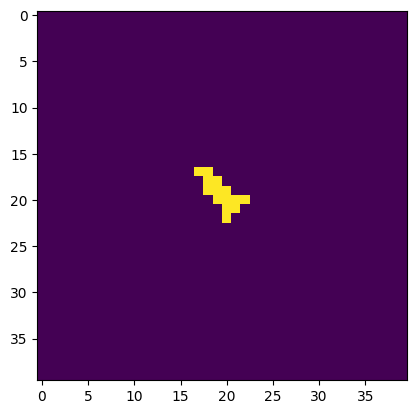

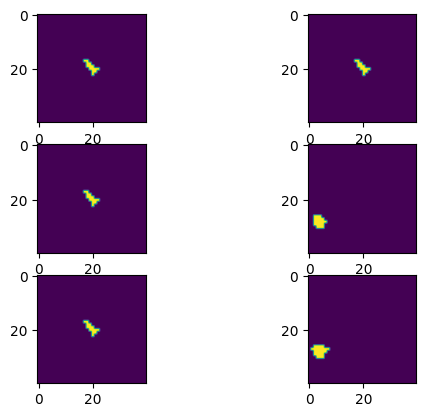

In [588]:
i = int(random.random() * len(data))

res = model.predict(data[i:i+1])[0]
res = np.where(res > 0.5, 1, 0)

print(i)

plt.imshow(data[i][0].reshape((diam,diam)))
plt.show()

prediction = res.reshape((len(days), diam, diam))
ground_truth = label[i].reshape((len(days), diam, diam))

fig, axs = plt.subplots(len(days), 2)
for i in range(len(days)):
    axs[i, 0].imshow(prediction[i])
    axs[i, 1].imshow(ground_truth[i])

In [590]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'model')